# Airline Arrivals 

In this challenge, we're going to predict how late flights will be. We'll constitute a flight as late only if it is more than 30 minutes late. 

The data is from the bureau of transportation statistics (link provided below) using the most recent available data, October 2017 - 2018. 

https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp?pn=1 

In [1]:
#imports
import pandas as pd
import numpy as np

#visuals 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#import models
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

#ignore warnings 
import warnings
warnings.filterwarnings("ignore")

#time
import time

In [2]:
df = pd.read_csv('https://www.dropbox.com/s/1e05pifam1ozfci/254169325_102018_2722_airline_delay_causes.csv?dl=1') 
df.columns

Index([u'year', u' month', u'carrier', u'carrier_name', u'airport',
       u'airport_name', u'arr_flights', u'arr_del15', u'carrier_ct',
       u' weather_ct', u'nas_ct', u'security_ct', u'late_aircraft_ct',
       u'arr_cancelled', u'arr_diverted', u' arr_delay', u' carrier_delay',
       u'weather_delay', u'nas_delay', u'security_delay',
       u'late_aircraft_delay', u'Unnamed: 21'],
      dtype='object')

In [3]:
df.rename(columns={u'year':'year', u' month':'month', u'carrier':'carrier', u'carrier_name':'carrier_name', u'airport':'airport',
       u'airport_name':'airport_name', u'arr_flights':'arr_flights', u'arr_del15':'arr_del15', u'carrier_ct':'carrier_ct',
       u' weather_ct':'weather_ct', u'nas_ct':'nas_ct', u'security_ct':'security_ct', u'late_aircraft_ct':'late_aircraft_ct',
       u'arr_cancelled':'arr_cancelled', u'arr_diverted':'arr_diverted', u' arr_delay':'arr_delay', u' carrier_delay':'carrier_delay',
       u'weather_delay':'weather_delay', u'nas_delay':'nas_delay', u'security_delay':'security_delay',
       u'late_aircraft_delay':'late_aircraft_delay', u'Unnamed: 21':'Unnamed: 21'}, inplace=True) 
df = df.drop(['carrier_name', 'airport_name', 'Unnamed: 21'], axis=1)
df.head()

,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2017,10,AA,ABQ,198.0,32.0,15.37,0.78,10.10,0.88,4.86,0.0,1.0,1195.0,513.0,88.0,302.0,28.0,264.0
1,2017,10,AA,ALB,86.0,12.0,4.93,0.00,2.38,0.00,4.69,0.0,0.0,473.0,236.0,0.0,98.0,0.0,139.0
2,2017,10,AA,AMA,31.0,5.0,1.55,0.00,0.90,0.00,2.55,0.0,0.0,210.0,69.0,0.0,48.0,0.0,93.0
3,2017,10,AA,ANC,4.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017,10,AA,ATL,950.0,137.0,50.67,0.79,48.50,1.17,35.87,3.0,0.0,6557.0,2701.0,50.0,1404.0,48.0,2354.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19915 entries, 0 to 19914
Data columns (total 19 columns):
year                   19915 non-null int64
month                  19915 non-null int64
carrier                19915 non-null object
airport                19915 non-null object
arr_flights            19896 non-null float64
arr_del15              19892 non-null float64
carrier_ct             19896 non-null float64
weather_ct             19896 non-null float64
nas_ct                 19896 non-null float64
security_ct            19896 non-null float64
late_aircraft_ct       19896 non-null float64
arr_cancelled          19896 non-null float64
arr_diverted           19896 non-null float64
arr_delay              19896 non-null float64
carrier_delay          19896 non-null float64
weather_delay          19896 non-null float64
nas_delay              19896 non-null float64
security_delay         19896 non-null float64
late_aircraft_delay    19896 non-null float64
dtypes: float64(15), in

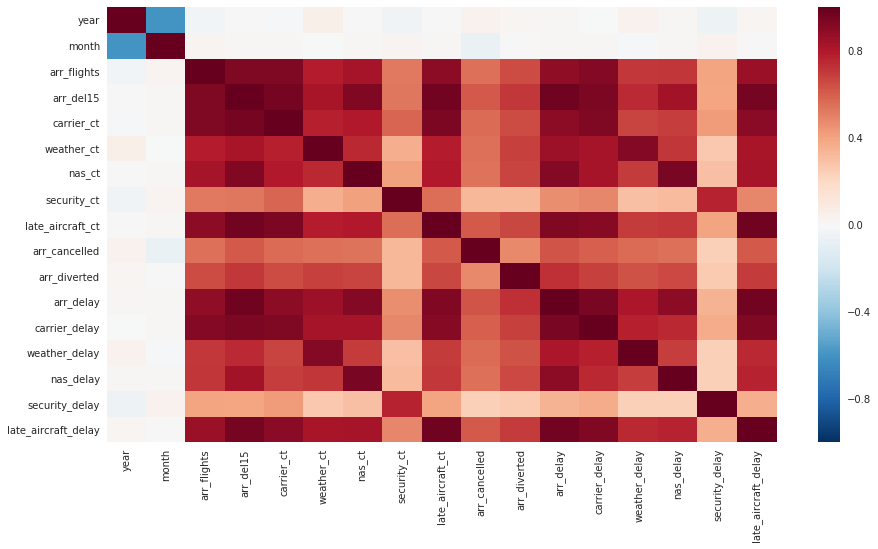

In [5]:
#set plot parameters
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.rcParams.update({'font.size': 15})
#check variable correlation 
sns.heatmap(df.corr())
plt.show()

We're very obviously going to need to use PCA to reduce this highly correlated feature set down. 

In [6]:
#Set our outcome to 0 and 1.
df['arr_late'] = np.where(df['arr_delay']>30, 1, 0)
df = df.drop(['arr_delay'], axis=1)

In [7]:
# Make the categorical variable 'airport' and 'carrier' into dummies.
#Create Dummy variables fort he sales column
cat_feats = ['airport']
data = pd.get_dummies(df, columns=cat_feats, drop_first=True)
data.head()

,year,month,carrier,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,...,airport_USA,airport_VEL,airport_VLD,airport_VPS,airport_WRG,airport_WYS,airport_XNA,airport_YAK,airport_YNG,airport_YUM
0,2017,10,AA,198.0,32.0,15.37,0.78,10.10,0.88,4.86,...,0,0,0,0,0,0,0,0,0,0
1,2017,10,AA,86.0,12.0,4.93,0.00,2.38,0.00,4.69,...,0,0,0,0,0,0,0,0,0,0
2,2017,10,AA,31.0,5.0,1.55,0.00,0.90,0.00,2.55,...,0,0,0,0,0,0,0,0,0,0
3,2017,10,AA,4.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
4,2017,10,AA,950.0,137.0,50.67,0.79,48.50,1.17,35.87,...,0,0,0,0,0,0,0,0,0,0


In [8]:
cat_feats2 = ['carrier']
data_2 = pd.get_dummies(data, columns=cat_feats2, drop_first=True)
data_2.head()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,...,carrier_HA,carrier_MQ,carrier_NK,carrier_OH,carrier_OO,carrier_UA,carrier_VX,carrier_WN,carrier_YV,carrier_YX
0,2017,10,198.0,32.0,15.37,0.78,10.10,0.88,4.86,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2017,10,86.0,12.0,4.93,0.00,2.38,0.00,4.69,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2017,10,31.0,5.0,1.55,0.00,0.90,0.00,2.55,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2017,10,4.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2017,10,950.0,137.0,50.67,0.79,48.50,1.17,35.87,3.0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#clean data to fit model
data_2.fillna(0, inplace=True)
for col in data_2.iloc[:, 1:]:
    data_2[col] = data_2[col].replace('[^0-9]+', '', regex=True)
    data_2[col] = data_2[col].astype('int64') 

In [10]:
Y = data_2['arr_late']
X = data_2.loc[:, ~data_2.columns.isin(['arr_late'])]

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)

In [12]:
#Will use test train split 
X_train, X_test, Y_train, Y_test = train_test_split(X_pca,Y, test_size=0.3)
print(X_train.shape)
print(Y_train.shape)

(13940, 20)
(13940,)


### Random Forest Classifier

In [13]:
rfc = ensemble.RandomForestClassifier()
rfc_model = rfc.fit(X_train, Y_train)

cross_val_score(rfc, X_train, Y_train, cv=5) 

array([0.99569738, 0.99713056, 0.99677188, 0.9982066 , 0.99892357])

In [14]:
start_time = time.time()
print(rfc.score(X_test, Y_test))
print("--- %s seconds ---" % (time.time() - start_time))

0.9969874476987448
--- 0.00976204872131 seconds ---


In [15]:
#test accuracy of Random Forest using Confusion matrix 
rfc_Y_pred = rfc.predict(X_test)
confusion_matrix(Y_test,rfc_Y_pred)

array([[ 267,   10],
       [   8, 5690]])

Only 10 False Positives and 8 False Negative, thus we mislabled 10 flights as late when they in fact weren't and missed 8 flight to classify as late. 

### Support Vector Machine

In [16]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, Y_train)
cross_val_score(svc, X_test, Y_test, cv=5)

array([0.98411371, 0.98411371, 0.98828452, 0.98827471, 0.98994975])

In [17]:
start_time = time.time()
print(svc.score(X_test, Y_test))
print("--- %s seconds ---" % (time.time() - start_time))

0.9923012552301256
--- 3.19789195061 seconds ---


In [18]:
#test accuracy of SVM using Confusion matrix 
svc_Y_pred = svc.predict(X_test)
confusion_matrix(Y_test,svc_Y_pred)

array([[ 232,   45],
       [   1, 5697]])

45 False Positives and 1 False Negative, thus we mislabled 45 flights as late when they in fact weren't but only missed one flight to classify as late! 